In [1]:
from gdc.data_access import *
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_squared_error
from arch import arch_model
import matplotlib.pyplot as plt

In [2]:
## OLS price ~ cons + temp

model = smf.ols(
    formula='{price} ~ {cons} + {temp}'.format(**CB.__dict__), 
    data=df_merged_real).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Price_EUR_MWh   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     1471.
Date:                Tue, 11 Nov 2025   Prob (F-statistic):               0.00
Time:                        08:37:18   Log-Likelihood:                -44610.
No. Observations:                8760   AIC:                         8.923e+04
Df Residuals:                    8757   BIC:                         8.925e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      102.4348     22.141      4.627      0.000      59.033     145.836
Consommation     0.0010   2.51e-05     40.828      0.000       0.001       0.001
Temp            -0.3748      0.072     -5.218      0.000      -0.516      -0.234
==============================================================================
Omnibus:                      381.737   Durbin-Watson:                   0.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              441.773
Skew:                          -0.506   Prob(JB):                     1.18e-96
Kurtosis:                       3.431   Cond. No.                     5.34e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [3]:
## OLS price ~ cons + temp + Dtemp^2

model = smf.ols(
    formula='{price} ~ {cons} + {temp} + {dtemp2}'.format(**CB.__dict__), 
    data=df_merged_real).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Price_EUR_MWh   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     1071.
Date:                Tue, 11 Nov 2025   Prob (F-statistic):               0.00
Time:                        08:37:18   Log-Likelihood:                -44509.
No. Observations:                8760   AIC:                         8.903e+04
Df Residuals:                    8756   BIC:                         8.906e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      302.2978     25.980     11.636      0.000     251.372     353.224
Consommation     0.0008   2.81e-05     29.812      0.000       0.001       0.001
Temp            -1.0262      0.084    -12.159      0.000      -1.192      -0.861
DTemp_2          0.1052      0.007     14.282      0.000       0.091       0.120
==============================================================================
Omnibus:                      382.372   Durbin-Watson:                   0.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              440.036
Skew:                          -0.511   Prob(JB):                     2.80e-96
Kurtosis:                       3.400   Cond. No.                     6.34e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [4]:
X = model.model.exog
vif = pd.Series(
    [variance_inflation_factor(X, i) for i in range(X.shape[1])],
    index=model.model.exog_names)
print(vif)


Intercept       3897.220078
Consommation       1.939110
Temp               2.139064
DTemp_2            1.449049
dtype: float64


In [5]:
y = df_merged_real[CB.price]
X = df_merged_real[[CB.cons]]

model = SARIMAX(y, exog=X, order=(2,0,0))  # 2 autoregressive lags, no differencing
res = model.fit()
print(res.summary())


y = res.model.endog
y_hat = res.fittedvalues

r2 = r2_score(y, y_hat)
print("Pseudo R²:", r2)

/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:          Price_EUR_MWh   No. Observations:                 8760
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -34675.375
Date:                Tue, 11 Nov 2025   AIC                          69358.750
Time:                        08:37:19   BIC                          69387.061
Sample:                    01-01-2023   HQIC                         69368.396
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Consommation     0.0009   1.22e-05     72.055      0.000       0.001       0.001
ar.L1            1.3993      0.007    199.140      0.000       1.386       1.413
ar.L2           -0.5084      0.008    -66.86

In [6]:
df_merged_real["hour"] = df_merged_real.index.hour
df_merged_real["dow"] = df_merged_real.index.dayofweek       # 0=Mon
df_merged_real["month"] = df_merged_real.index.month

df_merged_real["hour"]  = pd.Categorical(df_merged_real["hour"],  categories=range(24), ordered=False)
df_merged_real["dow"]   = pd.Categorical(df_merged_real["dow"],   categories=range(7),  ordered=False)
df_merged_real["month"] = pd.Categorical(df_merged_real["month"], categories=range(1,13), ordered=False)

# One-hot encode (omit one category to avoid collinearity)
D = pd.get_dummies(df_merged_real[["hour","dow","month"]],
                   drop_first=True, prefix=["h","d","m"], dtype=float)

In [7]:
X = pd.concat([df_merged_real[[CB.cons]], D], axis=1)

y = df_merged_real[CB.price]

model = SARIMAX(
    y,
    exog=sm.add_constant(X),
    order=(2,0,0),
    seasonal_order=(1,0,0,24),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

res = model.fit(disp=False)
print(res.summary())
y_hat = res.fittedvalues

r2 = r2_score(y, y_hat)
print("Pseudo R²:", r2)

/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                      Price_EUR_MWh   No. Observations:                 8760
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 24)   Log Likelihood              -32695.667
Date:                            Tue, 11 Nov 2025   AIC                          65483.334
Time:                                    08:38:16   BIC                          65808.783
Sample:                                01-01-2023   HQIC                         65594.242
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -129.3013     11.881    -10.883      0.000    -152.587    -106.016
Consommation     0.0020   7.5

In [8]:
eps = res.resid.dropna()  # SARIMAX residuals (mean-adjusted)

# 2) Fit a vanilla GARCH(1,1) with Student-t innovations (robust to spikes)
garch = arch_model(eps, mean='Zero', vol='GARCH', p=1, q=1, dist='t')
garch_res = garch.fit(disp='off')
print(garch_res.summary())

# Quick check: stationarity of volatility
alpha1 = garch_res.params.get('alpha[1]', float('nan'))
beta1  = garch_res.params.get('beta[1]', float('nan'))
print(f"alpha+beta = {alpha1 + beta1:.3f}  (should be < 1 for stationary variance)")

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -31940.7
Distribution:      Standardized Student's t   AIC:                           63889.4
Method:                  Maximum Likelihood   BIC:                           63917.7
                                              No. Observations:                 8760
Date:                      Tue, Nov 11 2025   Df Residuals:                     8760
Time:                              08:38:16   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega         25

### checking parameter stability

In [9]:
SPLIT_DATE = "2023-07-01"      # example: H1 vs H2
ORDER = (2,0,0)                 # your baseline
SEASONAL_ORDER = (1,0,0,24)

left_mask  = X.index <  pd.to_datetime(SPLIT_DATE)
right_mask = X.index >= pd.to_datetime(SPLIT_DATE)

X1, y1 = X.loc[left_mask],  y.loc[left_mask]
X2, y2 = X.loc[right_mask], y.loc[right_mask]

def fit_sarimax(y, X, order=ORDER, seasonal_order=SEASONAL_ORDER):
    mod = SARIMAX(
        y, exog=X, order=order, seasonal_order=seasonal_order,
        enforce_stationarity=False, enforce_invertibility=False
    )
    res = mod.fit(disp=False)
    # In-sample fitted values and pseudo R²
    y_hat = res.fittedvalues
    r2 = r2_score(y, y_hat)
    return res, r2

res1, r2_1 = fit_sarimax(y1, X1)
res2, r2_2 = fit_sarimax(y2, X2)

print("=== SAMPLE 1 ===")
print(res1.summary())
print("Pseudo R² (S1):", round(r2_1, 4))

print("\n=== SAMPLE 2 ===")
print(res2.summary())
print("Pseudo R² (S2):", round(r2_2, 4))

/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


=== SAMPLE 1 ===
                                     SARIMAX Results                                      
Dep. Variable:                      Price_EUR_MWh   No. Observations:                 4344
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 24)   Log Likelihood              -15966.138
Date:                            Tue, 11 Nov 2025   AIC                          32022.275
Time:                                    08:39:23   BIC                          32308.950
Sample:                                01-01-2023   HQIC                         32123.500
                                     - 06-30-2023                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Consommation     0.0012   6.08e-05     19.026      0.000       0.001       0.001
h_1         

/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse


In [10]:
def extract_metrics(res, r2):
    return {
        "n_obs":       int(res.nobs),
        "loglike":     float(res.llf),
        "AIC":         float(res.aic),
        "BIC":         float(res.bic),
        "sigma2":      float(res.params.get("sigma2", np.nan)),
        "AR1":         float(res.params.get("ar.L1", np.nan)),
        "AR2":         float(res.params.get("ar.L2", np.nan)),
        "SAR24":       float(res.params.get("ar.S.L24", np.nan)),
        "Consommation":float(res.params.get("Consommation", np.nan)),
        "R2_pseudo":   float(r2),
    }

cmp = pd.DataFrame({
    "Sample 1": extract_metrics(res1, r2_1),
    "Sample 2": extract_metrics(res2, r2_2),
})
print(cmp)


                  Sample 1      Sample 2
n_obs          4344.000000   4416.000000
loglike      -15966.137606 -16717.649920
AIC           32022.275213  33525.299839
BIC           32308.949855  33812.718642
sigma2          116.558529    128.043887
AR1               1.023268      1.191083
AR2              -0.121139     -0.309456
SAR24             0.536052      0.441819
Consommation      0.001158      0.002215
R2_pseudo         0.954242      0.928652


In [11]:
b1 = res1.params
b2 = res2.params

# 2. Identify dummy groups
hour_cols = [c for c in b1.index if c.startswith("h_")]
dow_cols  = [c for c in b1.index if c.startswith("d_")]

# 3. Build tidy DataFrames
hour_df = pd.DataFrame({
    "hour": [int(c.split("_")[1]) for c in hour_cols],
    "Sample 1": b1[hour_cols].values,
    "Sample 2": b2[hour_cols].values
}).sort_values("hour")

dow_df = pd.DataFrame({
    "dow": [int(c.split("_")[1]) for c in dow_cols],
    "Sample 1": b1[dow_cols].values,
    "Sample 2": b2[dow_cols].values
}).sort_values("dow")

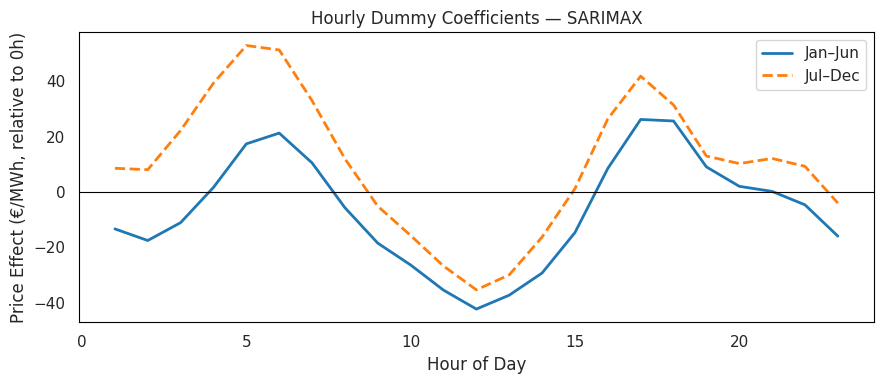

In [12]:
plt.figure(figsize=(9,4))
plt.plot(hour_df["hour"], hour_df["Sample 1"], label="Jan–Jun", lw=2)
plt.plot(hour_df["hour"], hour_df["Sample 2"], label="Jul–Dec", lw=2, ls="--")
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Hour of Day")
plt.ylabel("Price Effect (€/MWh, relative to 0h)")
plt.title("Hourly Dummy Coefficients — SARIMAX")
plt.legend()
plt.tight_layout()
plt.show()


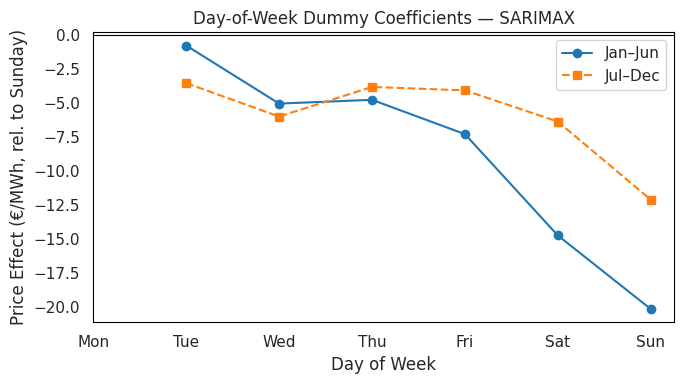

In [13]:
plt.figure(figsize=(7,4))
plt.plot(dow_df["dow"], dow_df["Sample 1"], "o-", label="Jan–Jun")
plt.plot(dow_df["dow"], dow_df["Sample 2"], "s--", label="Jul–Dec")
plt.axhline(0, color="k", lw=0.8)
plt.xticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.xlabel("Day of Week")
plt.ylabel("Price Effect (€/MWh, rel. to Sunday)")
plt.title("Day-of-Week Dummy Coefficients — SARIMAX")
plt.legend()
plt.tight_layout()
plt.show()
